# Final Project
## Gender Bias 
__Lucas Calero Forero, Rebecca McBrayer__

In [4]:
import os
import string
import re

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [219]:
max_line_length = 800000

In [220]:
def read_files(dir_name):
    english_corpus = []
    spanish_corpus = []
    french_corpus = []
    german_corpus = []  
    for filename in os.listdir(dir_name):
        if '.en' in filename[-3:] or '.en.' in filename:
            with open(f'{dir_name}/{filename}') as f:
                english_corpus.extend(f.readlines())
        if '.es' in filename[-3:] or '.es.' in filename:
            with open(f'{dir_name}/{filename}') as f:
                spanish_corpus.extend(f.readlines())
        if '.fr' in filename[-3:] or '.fr.' in filename:
            with open(f'{dir_name}/{filename}') as f:
                french_corpus.extend(f.readlines())
        if '.de' in filename[-3:] or '.de.' in filename:
            with open(f'{dir_name}/{filename}') as f:
                german_corpus.extend(f.readlines())
    return english_corpus[:max_line_length], spanish_corpus[:max_line_length], \
           french_corpus[:max_line_length], german_corpus[:max_line_length]

In [221]:
train_english, train_spanish, train_french, train_german = read_files('train')
dev_english, dev_spanish, dev_french, dev_german = read_files('dev')

In [222]:
def preprocess(corpus, train: bool):
    if not train:
        useful = []
        for item in corpus:
            if len(item)> 4 and '<seg' in item:
                start = item.find('">')
                end = item.find('</')
                useful.append(item[start+3:end].lower())
    else:
        useful = [sentence.lower() for sentence in corpus]
        

    # Remove punctuation
    exclude = set(string.punctuation)
    nopun = []
    for st in useful:
        st = ''.join(ch for ch in st if ch not in exclude)
        nopun.append(st)

    # Add start and ending tokens, and make all words lowercase
    data = [sentence.split() for sentence in nopun]
    data = list(filter(lambda a: len(a)>2, data))  # Remove blank sentences
    return data

In [223]:
train_english = preprocess(train_english,True)
dev_english = preprocess(dev_english,False)

print(len(train_english))
print(len(dev_english))

794854
15006


In [224]:
train_spanish = preprocess(train_spanish,True)
dev_spanish = preprocess(dev_spanish,False)

print(len(train_spanish))
print(len(dev_spanish))

790263
15006


In [225]:
train_french = preprocess(train_french,True)
dev_french = preprocess(dev_french,False)

print(len(train_french))
print(len(dev_french))

793714
15026


In [226]:
train_german = preprocess(train_german,True)
dev_german = preprocess(dev_german,False)

print(len(train_german))
print(len(dev_german))

790857
14986


In [227]:
english_data = train_english + dev_english
spanish_data = train_spanish + dev_spanish
french_data = train_french + dev_french
german_data = train_german + dev_german

In [229]:
# Train embeddings on the full corpuses

english_model = Word2Vec(sentences=english_data, size=300, window=7, min_count=2, workers=4, sg=1)
spanish_model = Word2Vec(sentences=spanish_data, size=300, window=7, min_count=2, workers=4, sg=1)
french_model = Word2Vec(sentences=french_data, size=300, window=7, min_count=2, workers=4, sg=1)
german_model = Word2Vec(sentences=german_data, size=300, window=7, min_count=2, workers=4, sg=1)

print(f'English vocab size: {len(english_model.wv.vocab)}')
print(f'Spanish vocab size: {len(spanish_model.wv.vocab)}')
print(f'French vocab size: {len(french_model.wv.vocab)}')
print(f'German vocab size: {len(german_model.wv.vocab)}')

English vocab size: 54635
Spanish vocab size: 88502
French vocab size: 79132
German vocab size: 137550


In [230]:
english_model.save("english.model")
spanish_model.save("spanish.model")
french_model.save("french.model")
german_model.save("german.model")

In [5]:
english_model = Word2Vec.load("english.model")
spanish_model = Word2Vec.load("spanish.model")
french_model = Word2Vec.load("french.model")
german_model = Word2Vec.load("german.model")

In [263]:
english_words = ['President', 'Governor', 'Militant', 'Slow', 'Dress', 'Actress', 'Actor', 'Game','Player', 'Roses', 'women', 'men', 'Mother', 'Father', 'Voters', 'User', 'Ambition', 'Vulnerable', 'Boss', 'Busy', 'Cousin', 'Police', 'Model', 'Professor']
spanish_words = ['Presidenta', 'Presidente', 'Gobernador', 'Militante', 'Lenta', 'Lento', 'vestido', 'actriz', 'actor', 'Juego', 'Jugador', 'Rosas', 'mujer', 'hombre', 'Madre', 'Padre', 'votantes', 'Usuario', 'Ambición', 'vulnerable', 'Jefe', 'ocupada', 'ocupado', 'primo', 'prima', 'policía', 'modelo', 'profesor', 'profesora']
french_words = ['Président', 'Présidente', 'Gouverneur', 'Militant', 'lente', 'actrice', 'robe', 'acteur', 'Jeu', 'Jouer', 'Roses', 'Femmes', 'Hommes', 'Mère', 'Père', 'électeurs', 'utilisateur', 'Ambition', 'vulnérable', 'patron', 'patronne', 'occupé', 'occupée', 'Cousine', 'police', 'modèle', 'professeur']
german_words = ['Präsident', 'Präsidentin', 'Gouverneur', 'Millitante', 'langsam', 'Schauspielerin', 'Kleid','Schauspieler', 'Spiel', 'Spieler', 'Frauen', 'Männer', 'Mutter', 'Vater', 'Wähler', 'Benutzer', 'Chef', 'Chefin',  'Polizei', 'Model', 'Professor', 'Professorin']

Removed words: Spanish - Gobernadora, jugadora, policia
               
               French - Gouverneure, lent, jouereuse, utilisatrice, cousin

               German - Gouverneurin, spielerin, Rosen, ehrgeiz, verletzlich, beschäftig, cousin, cousine

In [264]:
english_gender_pairs = [['man', 'woman'], ['he', 'she'], ['actor', 'actress'], \
                        ['brother', 'sister'], ['husband', 'wife'],\
                        ['father', 'mother'],['son', 'daughter'], ['king', 'queen']]
spanish_gender_pairs = [['hombre', 'mujer'], ['el', 'ella'], ['actor', 'actriz'], \
                        ['hermano', 'hermana'], ['esposo', 'esposa'],\
                        ['padre', 'madre'], ['hijo', 'hija'], ['rey', 'reina']]
french_gender_pairs = [['homme', 'femme'], ['il', 'elle'], ['acteur', 'actrice'], \
                       ['frère', 'sœur'], ['époux', 'épouse'], \
                       ['père', 'mère'], ['fils', 'fille'], ['roi', 'reine']]
german_gender_pairs = [['mann', 'frau'], ['er', 'sie'], ['schauspieler', 'schauspielerin'], \
                       ['bruder', 'schwester'], ['mann', 'ehefrau'],\
                       ['vater', 'mutter'], ['sohn', 'tochter'], ['könig', 'königin']]


def get_normalized_differences(model, pairs):
    differences = []
    for pair in pairs:
        norm_0 = model.wv[pair[0]]/np.linalg.norm(model.wv[pair[0]])
        norm_1 = model.wv[pair[1]]/np.linalg.norm(model.wv[pair[1]])
        differences.append(norm_0-norm_1)
    return differences

english_differences = get_normalized_differences(english_model, english_gender_pairs)
spanish_differences = get_normalized_differences(spanish_model, spanish_gender_pairs)
french_differences = get_normalized_differences(french_model, french_gender_pairs)
german_differences = get_normalized_differences(german_model, german_gender_pairs)

In [265]:
def get_gender_dimension(differences, visualize=True):
    pca = PCA()
    pca.fit(differences)
    
    if visualize:
        plt.bar(np.arange(8), pca.explained_variance_ratio_)
        plt.show()
    
    return pca.components_[0]

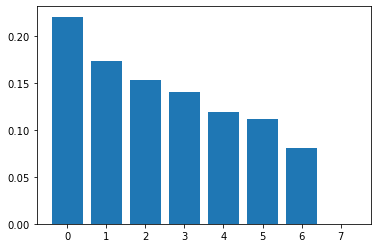

In [266]:
english_gd = get_gender_dimension(english_differences)

In [267]:
english_model.wv.similar_by_vector(english_gd)

[('actor', 0.3870496153831482),
 ('entity', 0.34634464979171753),
 ('mainstream', 0.2850078344345093),
 ('fora', 0.28196215629577637),
 ('representativeness', 0.27387499809265137),
 ('norms', 0.27328014373779297),
 ('interdependent', 0.2687690854072571),
 ('developmental', 0.2667452394962311),
 ('player', 0.26515331864356995),
 ('homogeneous', 0.2559206485748291)]

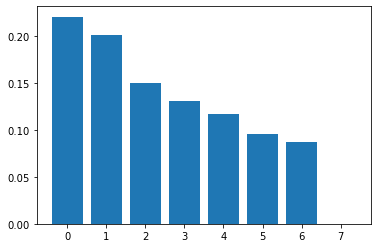

In [268]:
spanish_gd = get_gender_dimension(spanish_differences)

In [269]:
spanish_model.wv.similar_by_vector(spanish_gd)

[('el', 0.5803321003913879),
 ('del', 0.3509189188480377),
 ('de', 0.3069862127304077),
 ('–el', 0.3014705181121826),
 ('«el', 0.29340416193008423),
 ('\xad', 0.2808428406715393),
 ('com2003', 0.2781440317630768),
 ('autorizó', 0.26634785532951355),
 ('¿el', 0.26501867175102234),
 ('y', 0.26461419463157654)]

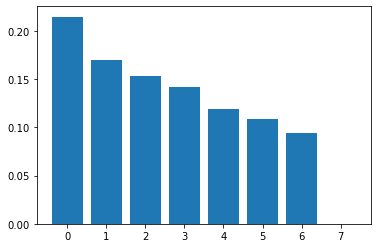

In [270]:
french_gd = get_gender_dimension(french_differences)

In [271]:
french_model.wv.similar_by_vector(french_gd)

[('acteur', 0.4420965909957886),
 ('scène', 0.28074365854263306),
 ('elle', 0.26503151655197144),
 ('influent', 0.2426709532737732),
 ('partenaire', 0.24154089391231537),
 ('concurrentiels', 0.21544647216796875),
 ('qu’acteur', 0.21181568503379822),
 ('quacteur', 0.2104436457157135),
 ('donateur', 0.21042898297309875),
 ('compétitifs', 0.20752541720867157)]

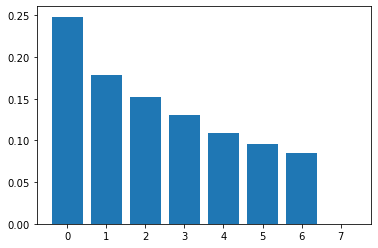

In [272]:
german_gd = get_gender_dimension(german_differences)

In [273]:
german_model.wv.similar_by_vector(german_gd)

[('mann', 0.5554859042167664),
 ('eingreiftruppe', 0.1988731324672699),
 ('truppe', 0.17532256245613098),
 ('verteidigung', 0.15899917483329773),
 ('starke', 0.1451280117034912),
 ('betrag', 0.14402683079242706),
 ('pro', 0.13702496886253357),
 ('gleichberechtigung', 0.1369360387325287),
 ('einheiten', 0.1359703689813614),
 ('bein', 0.1356247067451477)]

In [274]:
english_embeddings = [english_model.wv[word.lower()] for word in english_words]
spanish_embeddings = [spanish_model.wv[word.lower()] for word in spanish_words]
french_embeddings = [french_model.wv[word.lower()] for word in french_words]
german_embeddings = [german_model.wv[word.lower()] for word in german_words]

In [275]:
# Dictionary of words to normalized word embeddings
english_embed_dict = {word.lower(): english_model.wv[word.lower()]/np.linalg.norm(english_model.wv[word.lower()]) for word in english_words}
spanish_embed_dict = {word.lower(): spanish_model.wv[word.lower()]/np.linalg.norm(spanish_model.wv[word.lower()]) for word in spanish_words}
french_embed_dict = {word.lower(): french_model.wv[word.lower()]/np.linalg.norm(french_model.wv[word.lower()]) for word in french_words}
german_embed_dict = {word.lower(): german_model.wv[word.lower()]/np.linalg.norm(german_model.wv[word.lower()]) for word in german_words}

In [276]:
def gender_component(w, v, g):
    w_g = np.dot(w, g)*g
    w_perp = w-w_g
    w_perp_norm = np.linalg.norm(w_perp)
    
    v_g = np.dot(v, g)*g
    v_perp = v-v_g
    v_perp_norm = np.linalg.norm(v_perp)
    
    w_dot_v = np.dot(w, v)
    
    beta = (w_dot_v - np.dot(w_perp, v_perp)/(w_perp_norm*v_perp_norm))/w_dot_v
    return beta

In [277]:
gender_component(english_embed_dict['roses'], english_embed_dict['women'], english_gd)

-0.26679698266679513

In [278]:
def contribution_gender(w, g):
    w_g = np.dot(w, g)*g
    return w_g

def plot_gender_contribution_influence(embed_dict, gd, ):
    gender = [contribution_gender(embedding, gd) for embedding in embed_dict.values()]

    pca = PCA(n_components=2)
    pca.fit(gender)
    gender_transformed = pca.transform(gender)
    words = list(embed_dict.keys())
    y_pos = np.arange(len(words))

    plt.figure(figsize=(2.5*6.4, 2.5*4.8))
    plt.xticks(y_pos, words, color='black', rotation=55, fontweight='bold', fontsize='17', horizontalalignment='right')
    plt.grid(axis = 'x',color = 'gray', linewidth = 0.4)
    for i in range(len(gender_transformed)):
        x = i
        y = gender_transformed[i][1]
        color = 'b'
        if y < 0:
            color = 'orange'
        plt.bar(x, y, color=color)
    plt.show()

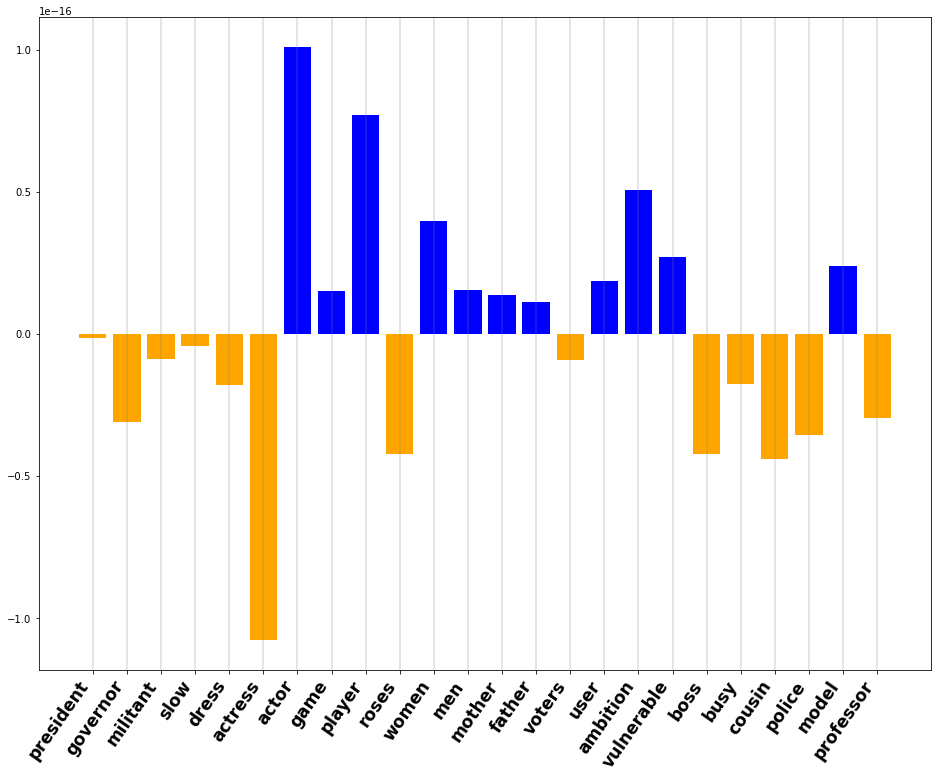

In [279]:
plot_gender_contribution_influence(english_embed_dict, english_gd)

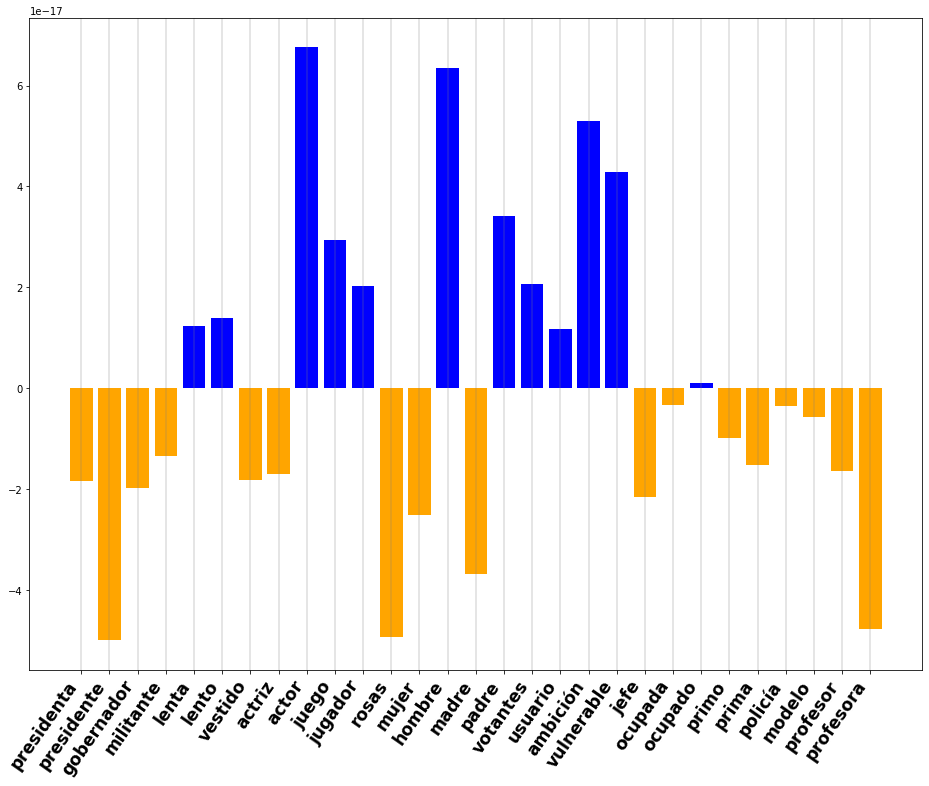

In [280]:
plot_gender_contribution_influence(spanish_embed_dict, spanish_gd)

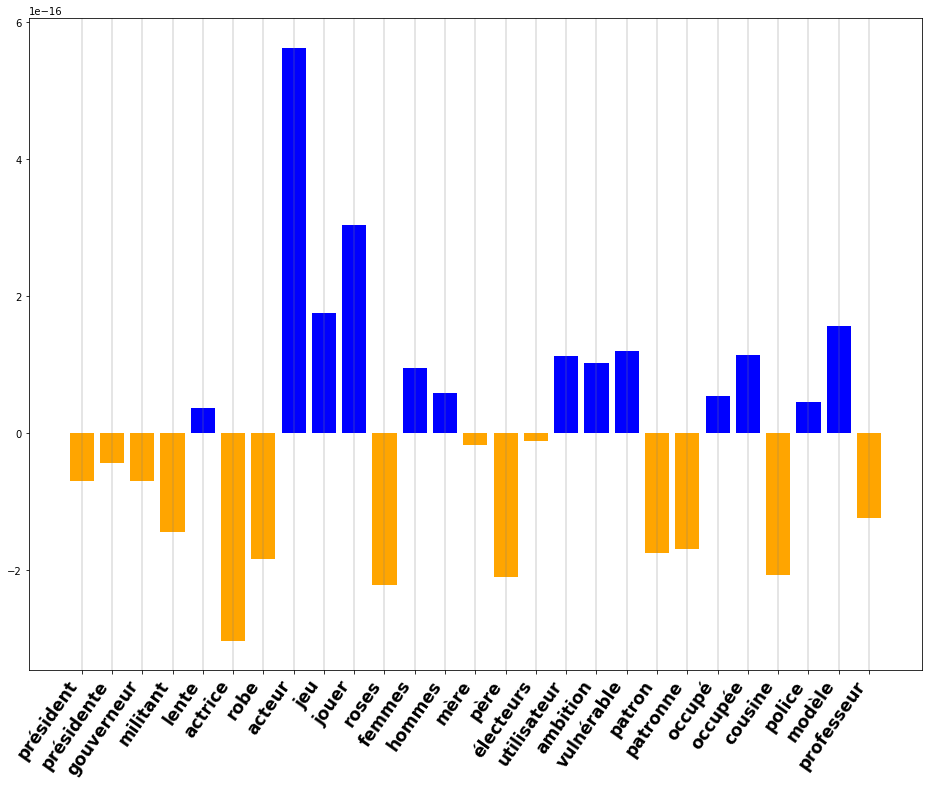

In [281]:
plot_gender_contribution_influence(french_embed_dict, french_gd)

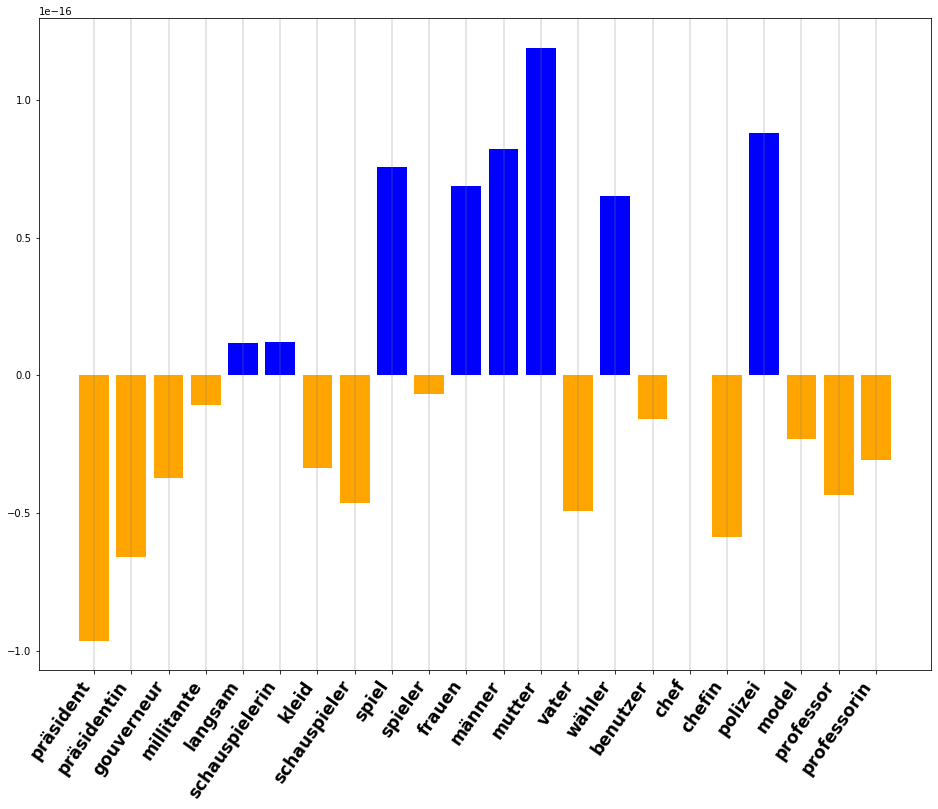

In [261]:
plot_gender_contribution_influence(german_embed_dict, german_gd)

In [262]:
def plot_gender_component_influence(embed_dict, gd, female_word, male_word):
    women = [-gender_component(embedding, embed_dict[female_word], gd) for embedding in embed_dict.values()]
    men = [-gender_component(embedding, embed_dict[male_word], gd) for embedding in embed_dict.values()]

    words = list(embed_dict.keys())
    plt.figure(figsize=(2.5*6.4, 2.5*4.8))
    for i in range(len(women)):
        x = men[i]
        y = women[i]
        plt.plot(x, y, 'bo')
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , words[i], fontsize=10)
    plt.show()

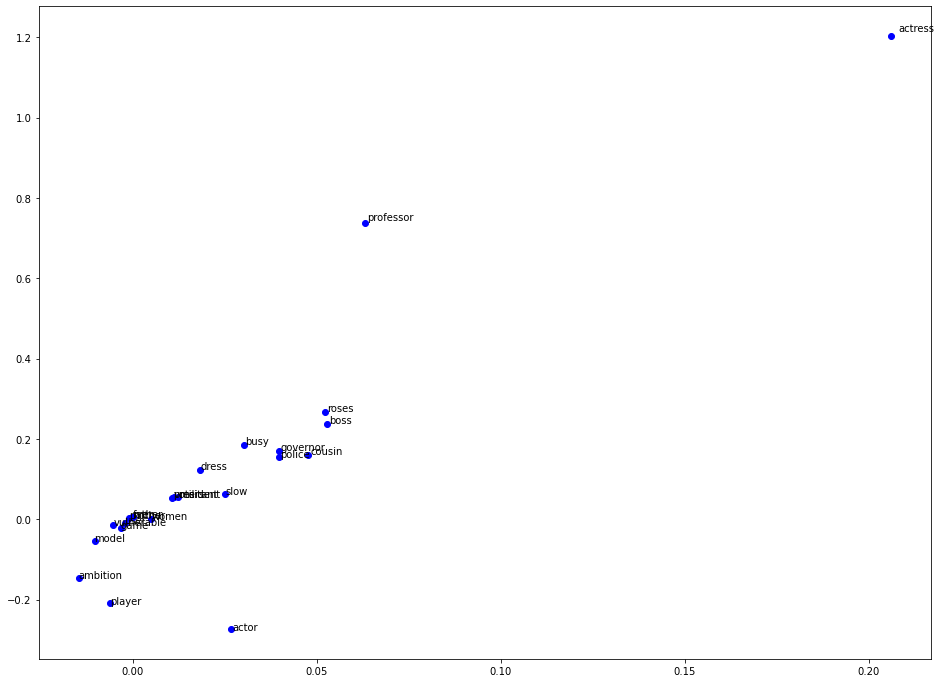

In [239]:
plot_gender_component_influence(english_embed_dict, english_gd, 'women', 'men')

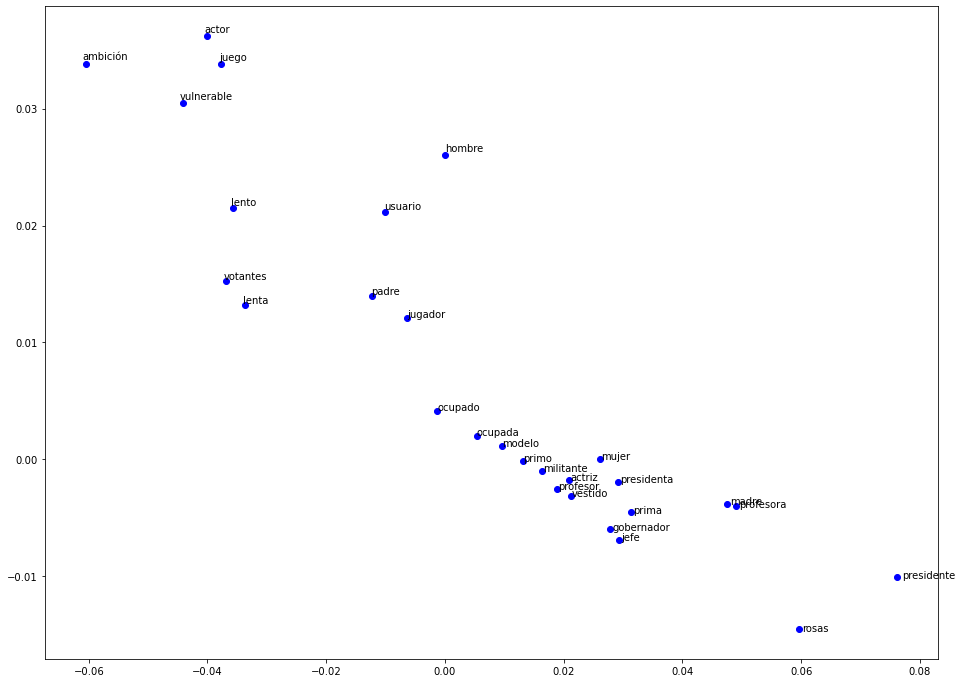

In [84]:
plot_gender_component_influence(spanish_embed_dict, spanish_gd, 'mujer', 'hombre')

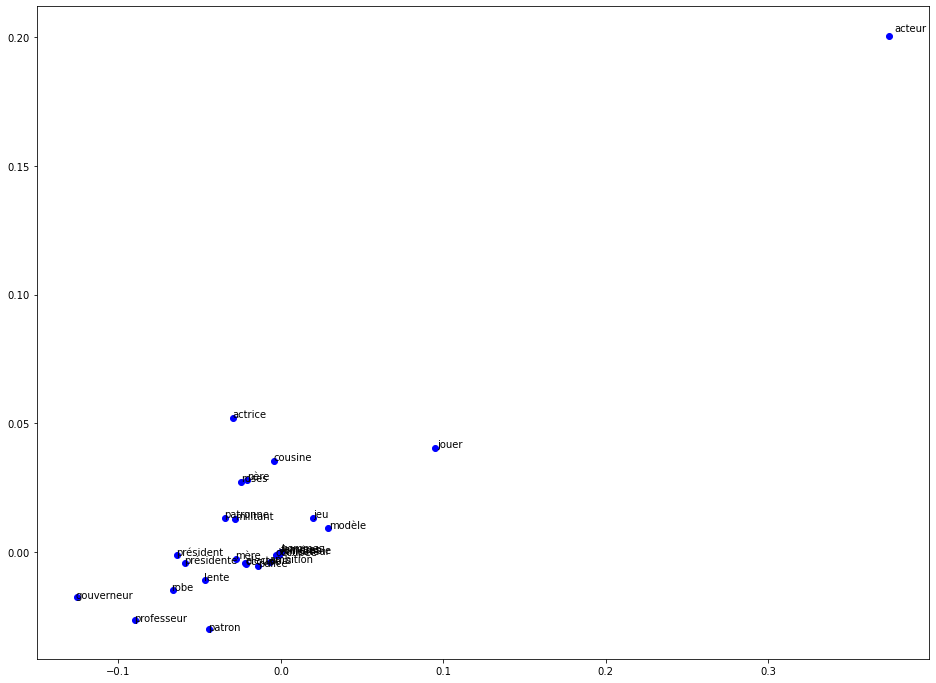

In [85]:
plot_gender_component_influence(french_embed_dict, french_gd, 'femmes', 'hommes')

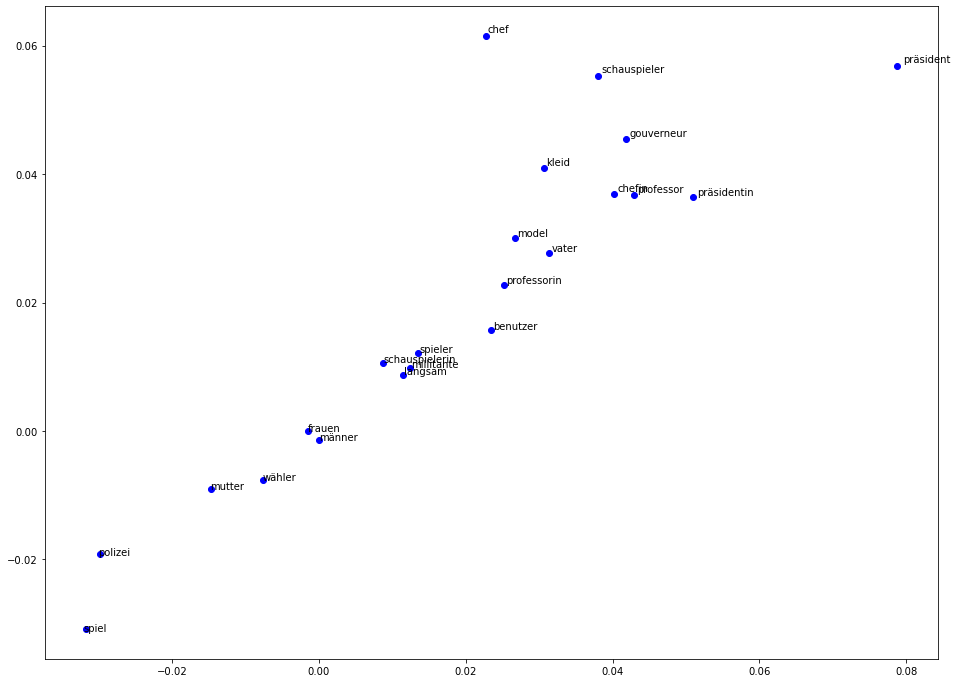

In [86]:
plot_gender_component_influence(german_embed_dict, german_gd, 'frauen', 'männer')

### Unused Data Exploration:

In [32]:
for word, embedding in english_embed_dict.items():
    for word2, embedding2 in english_embed_dict.items():
        gender = gender_component(embedding, embedding2, english_gd)
        if abs(round(gender, 2)) > 0:
            print(word, word2, round(gender, 5))

president militant 0.01215
president slow 0.01818
president actress -0.0223
president actor -0.18214
president game -0.00902
president dress 0.02755
president player -0.11293
president women -0.03087
president voters 0.01208
president user 0.14263
president ambition -0.0447
president vulnerable -0.03722
president boss 0.0122
president busy 0.01301
president police 0.09959
president model -0.01626
president professor 0.01173
governor militant 0.02366
governor slow 0.08933
governor actress 0.05835
governor actor -0.35534
governor game -0.06186
governor dress 0.0808
governor player -0.29927
governor roses 0.08612
governor women -0.14581
governor men -0.02556
governor mother -0.02564
governor father -0.00814
governor voters 0.0364
governor user -0.13645
governor ambition -0.41064
governor vulnerable -0.284
governor boss 0.05241
governor busy 0.09507
governor cousin 0.04169
governor police 0.10115
governor model -0.11048
governor professor 0.04965
militant president 0.01215
militant governo

In [174]:
for word, embedding in spanish_embed_dict.items():
    for word2, embedding2 in spanish_embed_dict.items():
        gender = round(gender_component(embedding, embedding2, spanish_gd), 2)
        if abs(gender) > 0:
            print(word, word2, gender)

presidenta jugador -0.1
presidenta señor -0.1
presidenta madre -0.1
presidenta votantes -0.1
presidenta modelo -0.1
presidente gobernador -0.1
presidente lenta -0.1
presidente lento -0.1
presidente vestido -0.2
presidente actriz -0.1
presidente actor -0.1
presidente juego -0.2
presidente jugador -0.3
presidente rosas -0.1
presidente señora -0.2
presidente señor -0.3
presidente madre -0.3
presidente padre -0.1
presidente votantes -0.3
presidente usuario -0.2
presidente ambición -0.1
presidente vulnerable -0.1
presidente ocupada -0.1
presidente ocupado -0.1
presidente primo -0.1
presidente prima -0.2
presidente modelo -0.3
presidente profesor -0.1
presidente profesora -0.1
gobernador presidente -0.1
gobernador señor -0.1
militante señor -0.1
militante votantes -0.1
militante modelo -0.1
lenta presidente -0.1
lento presidente -0.1
lento jefe -0.1
vestido presidente -0.2
vestido jefe -0.1
actriz presidente -0.1
actor presidente -0.1
actor jefe -0.1
juego presidente -0.2
juego jefe -0.1
jug

In [175]:
for word, embedding in french_embed_dict.items():
    for word2, embedding2 in french_embed_dict.items():
        gender = round(gender_component(embedding, embedding2, french_gd), 2)
        if abs(gender) > 0:
            print(word, word2, gender)

président militant 0.01
président lente 0.01
président robe 0.01
président actrice 0.01
président acteur 0.01
président jeu 0.02
président jouer 0.01
président roses 0.01
président femmes 0.01
président mère 0.01
président père 0.01
président utilisateur 0.01
président ambition 0.01
président patron 0.01
président patronne 0.01
président occupé 0.01
président occupée 0.01
président cousine 0.01
président police -0.02
président modèle 0.01
présidente jeu -0.01
présidente jouer -0.01
présidente père -0.01
présidente professeur -0.01
gouverneur jeu -0.01
gouverneur jouer -0.01
gouverneur père -0.01
gouverneur professeur -0.01
militant président 0.01
militant hommes -0.01
militant police -0.02
lente président 0.01
lente jeu -0.01
lente jouer -0.01
lente police -0.01
robe président 0.01
robe police -0.02
actrice président 0.01
actrice hommes -0.01
actrice police -0.02
acteur président 0.01
acteur hommes -0.01
acteur électeurs -0.01
acteur police -0.02
jeu président 0.02
jeu présidente -0.01

In [176]:
for word, embedding in german_embed_dict.items():
    for word2, embedding2 in german_embed_dict.items():
        gender = round(gender_component(embedding, embedding2, german_gd), 2)
        if abs(gender) > 0:
            print(word, word2, gender)

präsident präsidentin -0.14
präsident gouverneur -0.1
präsident millitante -0.16
präsident langsam -0.13
präsident kleid -0.11
präsident schauspielerin -0.07
präsident schauspieler -0.05
präsident spiel -0.05
präsident spieler -0.12
präsident frauen -0.31
präsident männer -0.2
präsident mutter -0.16
präsident vater -0.06
präsident wähler -0.12
präsident benutzer -0.2
präsident chef -0.1
präsident chefin -0.14
präsident polizei -0.07
präsident model -0.15
präsident professor -0.08
präsident professorin -0.12
präsidentin präsident -0.14
präsidentin schauspielerin -0.01
präsidentin schauspieler -0.01
präsidentin spiel -0.01
präsidentin männer 0.01
präsidentin mutter 0.01
präsidentin vater -0.01
präsidentin polizei -0.01
präsidentin professor -0.01
gouverneur präsident -0.1
gouverneur schauspieler -0.01
gouverneur spiel -0.01
gouverneur frauen -0.02
gouverneur männer -0.01
gouverneur benutzer -0.01
millitante präsident -0.16
millitante schauspielerin -0.01
millitante schauspieler -0.02
mil

In [165]:
gender_diff = english_embed_dict['men']-english_embed_dict['women']

for word, embedding in english_embed_dict.items():
    for word2, embedding2 in english_embed_dict.items():
        if word != word2 and 'men' not in word and 'men' not in word2:
            norm = np.linalg.norm(embedding-embedding2)
            if norm < 1:
                print(word, word2, np.dot(gender_diff, embedding-embedding2))

president governor -0.0019425792
president militant -0.006145278
president slow 0.03657881
president dress 0.04175341
president actress 0.03923607
president actor -0.03137803
president game 0.13183418
president roses 0.04731539
president father 0.01987448
president voters 0.036900222
president ambition 0.0029110303
president boss -0.0021079471
president busy 0.052831825
president cousin 0.010584817
president police -0.11488187
president professor -0.0015583369
governor president 0.0019425792
governor militant -0.0042026965
governor slow 0.038521394
governor dress 0.043695994
governor actress 0.041178647
governor actor -0.02943545
governor game 0.13377675
governor player 0.0706764
governor roses 0.049257964
governor mother 0.039010264
governor father 0.021817062
governor voters 0.0388428
governor user 0.06615415
governor ambition 0.00485361
governor vulnerable 0.0282825
governor boss -0.00016536599
governor busy 0.054774404
governor cousin 0.012527395
governor police -0.11293929
governo